In [1]:
%%capture
from pathlib import Path

if Path.cwd().stem == "notebooks":
    %cd ..
    %load_ext autoreload
    %autoreload 2

In [2]:
import holoviews as hv
import hvplot.polars  # noqa
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from polars import col

from src.data.database_manager import DatabaseManager
from src.features.scaling import scale_min_max
from src.features.transforming import map_by_group
from src.log_config import configure_logging
from src.plots.averages_over_stimulus_seeds import (
    add_ci_to_averages,
    average_over_stimulus_seeds,
    calculate_max_crosscorr_lag_over_averages,
    plot_averages_with_ci,
    plot_correlation_heatmap,
)

configure_logging(
    ignore_libs=("Comm", "bokeh", "tornado", "matplotlib"),
)

pl.Config.set_tbl_rows(12)  # for 12 seeds
hv.output(widget_location="bottom", size=150)

In [3]:
db = DatabaseManager()

In [ ]:
with db:
    df = db.get_table(
        "Merged_and_Labeled_Data",
        exclude_trials_with_measurement_problems=True,
    )

df = df.drop(["heart_rate", "pupil_mean"]).rename(
    {
        "rating": "pain_rating",
        # NOTE: using the non-causal data columns here
        "heart_rate_exploratory": "heart_rate",
        "pupil_mean_exploratory": "pupil_diameter",
        # eda tonic and phasic are already non-causally transformed
    }
)

In [26]:
signals = [
    "temperature",
    "pain_rating",
    "heart_rate",
    "pupil_diameter",
    "eda_tonic",
    "eda_phasic",
]


## Averaged trials over stimulus seeds with confidence intervals

In [27]:
averages = average_over_stimulus_seeds(
    df,
    signals,
    scaling="min_max",
    bin_size=0.1,
)
averges_with_ci = add_ci_to_averages(
    averages,
    signals,
    confidence_level=0.95,
)
plot_averages_with_ci(
    averges_with_ci,
    signals,
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'21840f09-822b-48bf-878d-bb8cb772fa68': {'version…

In [28]:
# Remove first 20 seconds
# NOTE: important for the paper
averages = averages.filter(col("time_bin") >= 20)

In [29]:
averages

stimulus_seed,avg_temperature,avg_pain_rating,avg_heart_rate,avg_pupil_diameter,avg_eda_tonic,avg_eda_phasic,std_temperature,std_pain_rating,std_heart_rate,std_pupil_diameter,std_eda_tonic,std_eda_phasic,sample_size,time_bin
u16,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,u32,f64
133,0.500538,0.227467,0.32728,0.518919,0.676605,0.413584,0.000826,0.224506,0.187357,0.208715,0.172302,0.112775,37,20.0
133,0.493263,0.215004,0.328641,0.518295,0.674198,0.416385,0.000839,0.218409,0.187039,0.206894,0.172405,0.113657,37,20.1
133,0.485975,0.204909,0.331326,0.516389,0.671846,0.417126,0.000835,0.215046,0.186661,0.2047,0.1725,0.112356,37,20.2
133,0.478646,0.196032,0.334625,0.513029,0.669451,0.415219,0.00087,0.211645,0.187749,0.200377,0.172533,0.111332,37,20.3
133,0.471355,0.188876,0.339779,0.51102,0.667009,0.416131,0.000873,0.207428,0.190516,0.197451,0.172667,0.11152,37,20.4
133,0.464048,0.1846,0.34653,0.51126,0.664692,0.417619,0.000873,0.204376,0.194662,0.196389,0.172784,0.111169,37,20.5
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
952,0.055794,0.045383,0.419163,0.324119,0.181705,0.40901,0.000191,0.126091,0.195895,0.217814,0.222388,0.107579,40,179.4
952,0.055265,0.042738,0.420505,0.319497,0.181679,0.409845,0.00015,0.123876,0.194198,0.218891,0.222381,0.10366,40,179.5


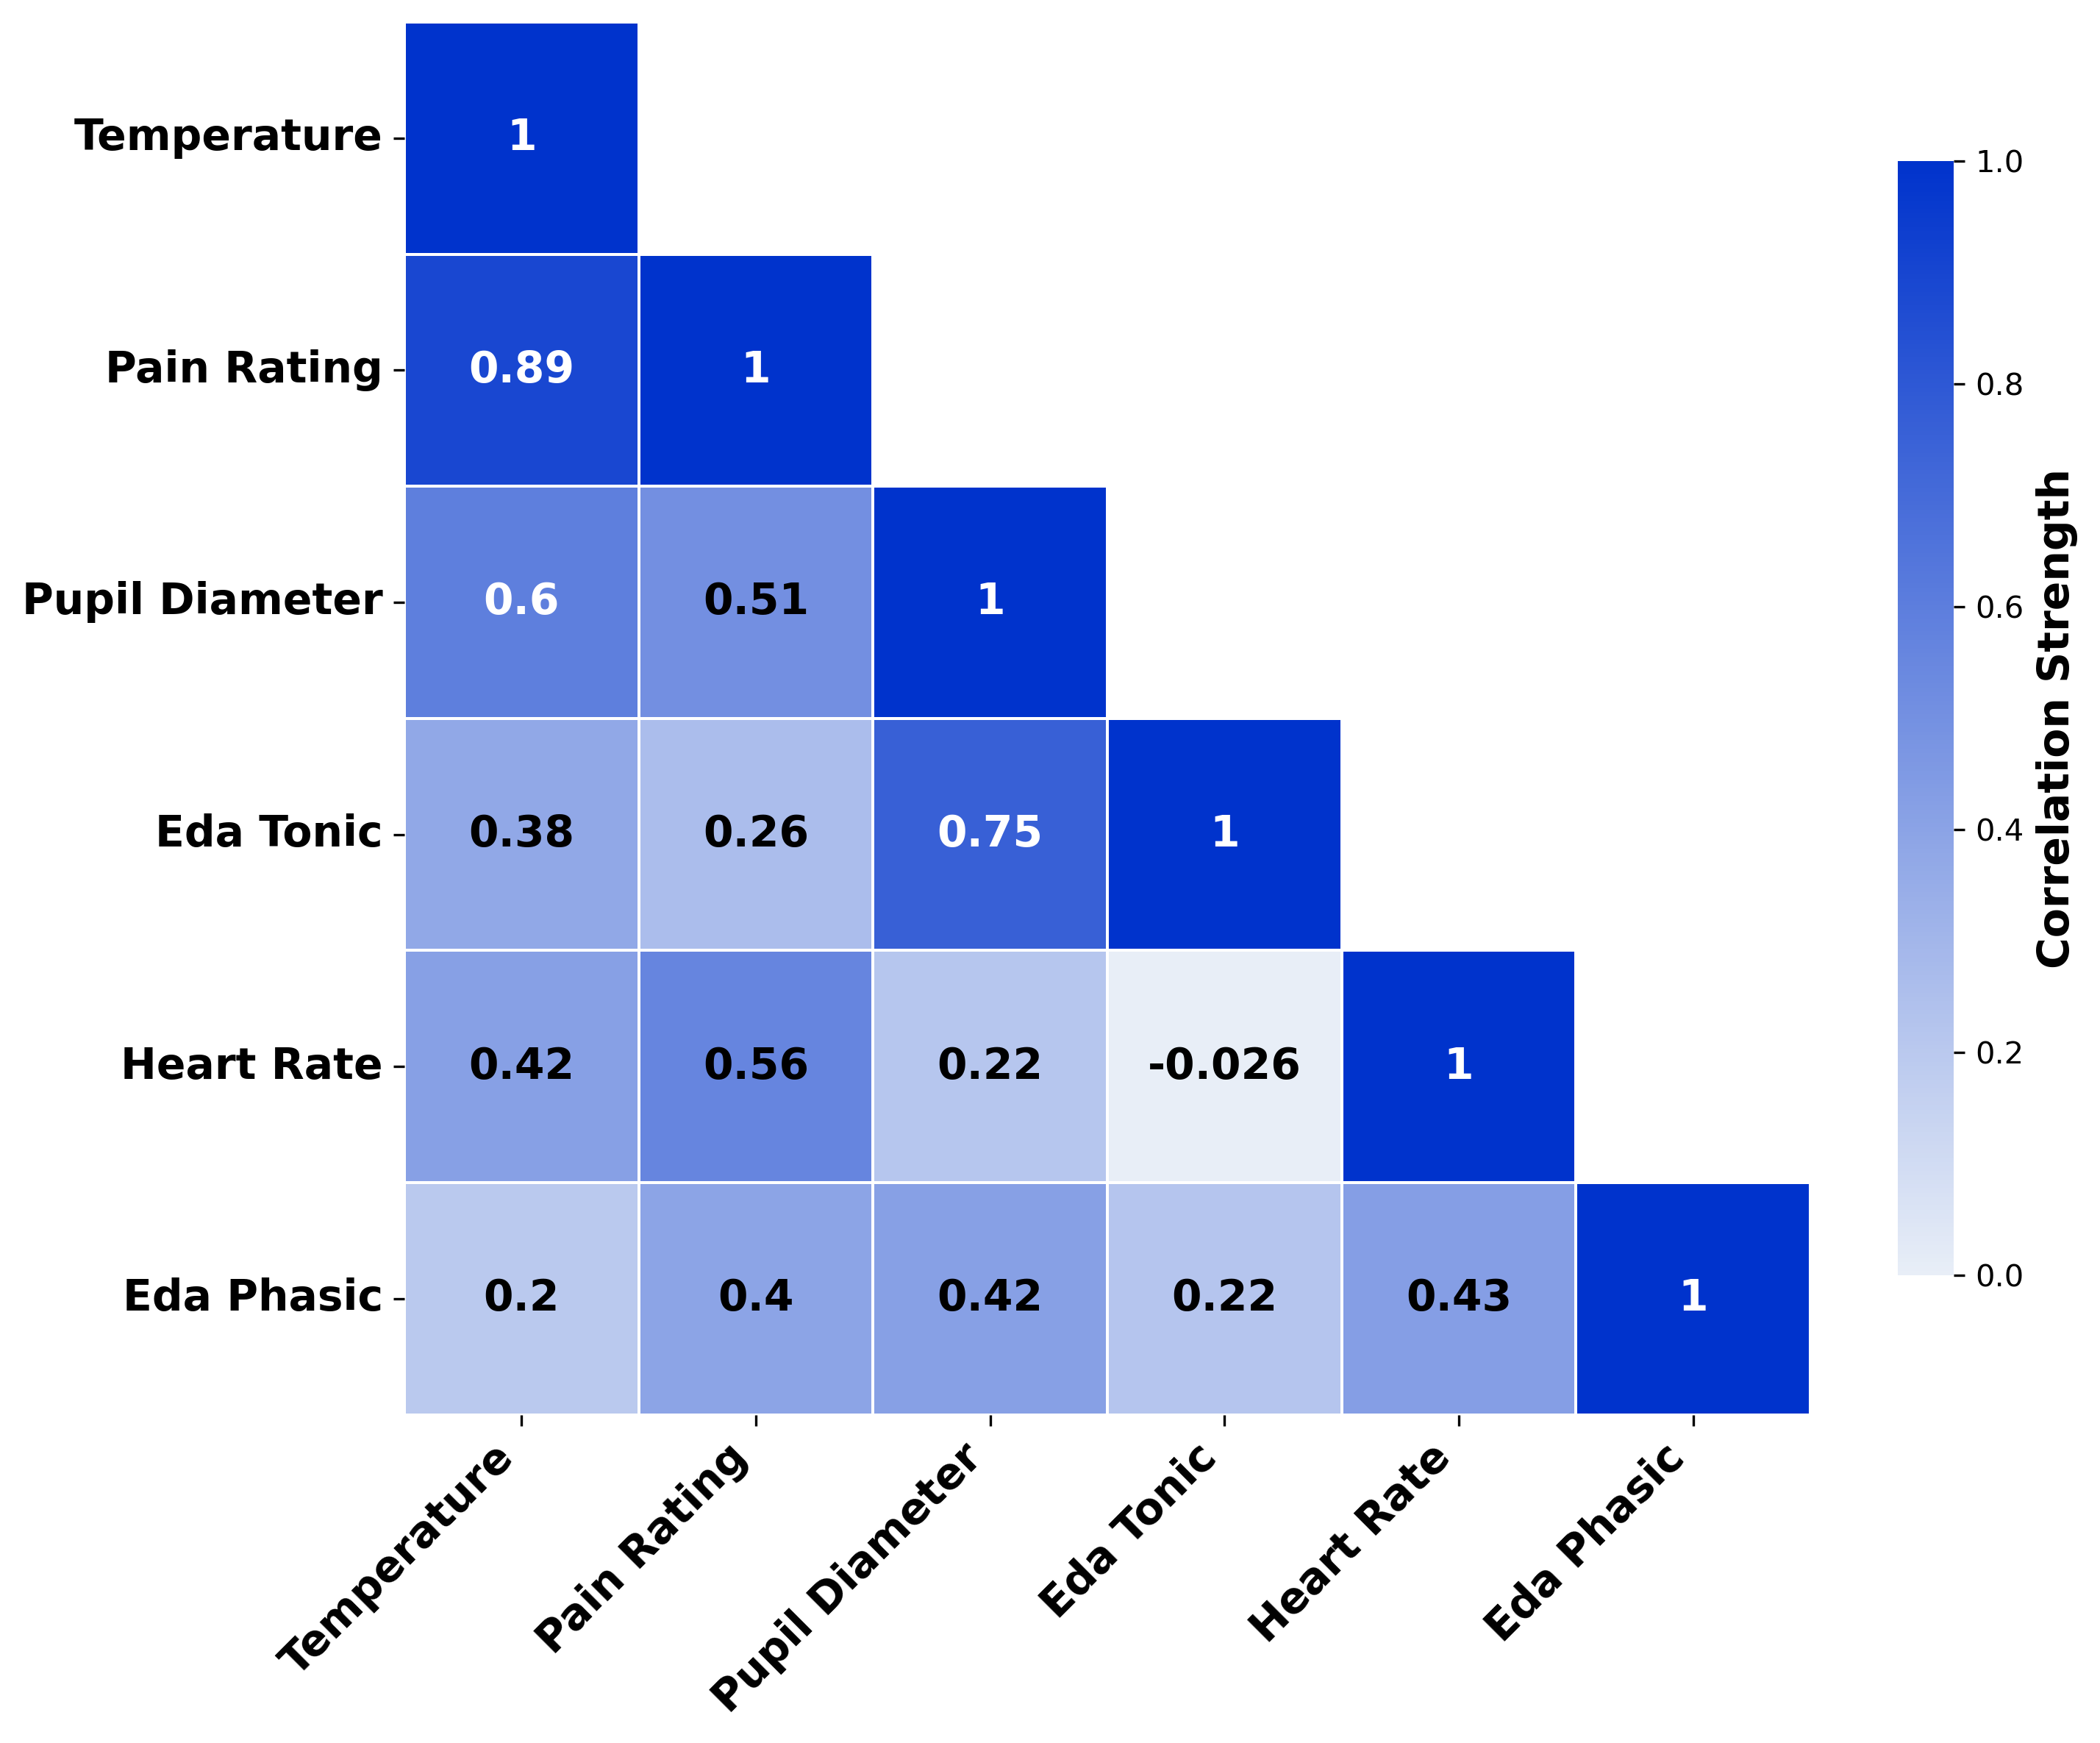

In [32]:
# without first 10 seconds
correlation_heatmap = plot_correlation_heatmap(averages)

In [34]:
# Sample code for correlations for each stimulus seed with standard deviation
correlations = []
for group in averages.group_by("stimulus_seed"):
    corr = group[1].select(pl.corr("avg_pupil_diameter", "avg_eda_phasic")).item()
    correlations.append(corr)
correlations = np.array(correlations)
correlations.mean().round(2), correlations.std().round(2)
correlations

array([0.36867003, 0.52306154, 0.45524987, 0.46689891, 0.44099659,
       0.42853027, 0.47444197, 0.44120182, 0.44188724, 0.50761635,
       0.49903974, 0.42271087])

## Cross correlation lags of grand means

In [35]:
# without first 20 seconds
for sig in signals:
    if sig == "temperature":
        continue
    col1 = "avg_temperature"
    col2 = f"avg_{sig}"
    calculate_max_crosscorr_lag_over_averages(
        averages,
        col1,
        col2,
        fs=10,
    )

16:03:47 | INFO    | averages_over_stimulus_seeds | avg_temperature : avg_pain_rating | mean lag: -1.01, std lag: 0.35
16:03:47 | INFO    | averages_over_stimulus_seeds | avg_temperature : avg_heart_rate | mean lag: -1.77, std lag: 1.43
16:03:47 | INFO    | averages_over_stimulus_seeds | avg_temperature : avg_pupil_diameter | mean lag: -0.13, std lag: 0.31
16:03:47 | INFO    | averages_over_stimulus_seeds | avg_temperature : avg_eda_tonic | mean lag: -1.06, std lag: 0.62
16:03:47 | INFO    | averages_over_stimulus_seeds | avg_temperature : avg_eda_phasic | mean lag: -2.32, std lag: 1.08


In [37]:
# without first 20 seconds
for sig in signals:
    if sig == "pain_rating":
        continue
    col1 = "avg_pain_rating"
    col2 = f"avg_{sig}"
    calculate_max_crosscorr_lag_over_averages(
        averages,
        col1,
        col2,
        fs=10,
    )
    # print(averages)

16:04:34 | INFO    | averages_over_stimulus_seeds | avg_pain_rating : avg_temperature | mean lag: 1.01, std lag: 0.35
16:04:34 | INFO    | averages_over_stimulus_seeds | avg_pain_rating : avg_heart_rate | mean lag: -0.38, std lag: 0.56
16:04:34 | INFO    | averages_over_stimulus_seeds | avg_pain_rating : avg_pupil_diameter | mean lag: 0.32, std lag: 0.54
16:04:34 | INFO    | averages_over_stimulus_seeds | avg_pain_rating : avg_eda_tonic | mean lag: -0.15, std lag: 0.25
16:04:34 | INFO    | averages_over_stimulus_seeds | avg_pain_rating : avg_eda_phasic | mean lag: -0.44, std lag: 0.44


16:04:44 | INFO    | averages_over_stimulus_seeds | avg_pain_rating : avg_heart_rate | mean lag: -0.38, std lag: 0.56


stimulus_seed,lag
u16,f64
133,0.0
243,0.0
265,0.0
396,0.0
467,-0.1
658,0.0
681,-1.7
743,-0.5
806,-0.8


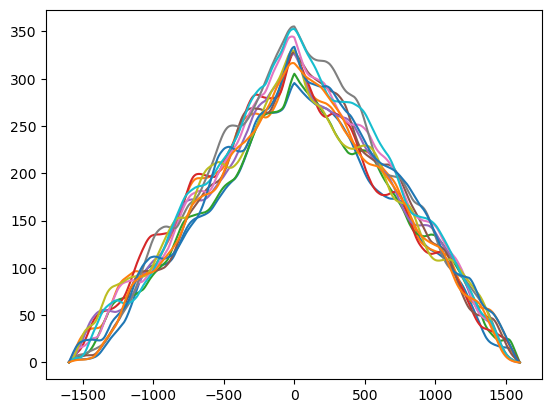

In [38]:
col1 = "avg_pain_rating"
col2 = "avg_heart_rate"
calculate_max_crosscorr_lag_over_averages(
    averages,
    col1,
    col2,
    fs=10,
    plot=True,
)

In [20]:
averages

stimulus_seed,avg_temperature,avg_rating,avg_heartrate,avg_pupil_mean,avg_eda_tonic,avg_eda_phasic,std_temperature,std_rating,std_heartrate,std_pupil_mean,std_eda_tonic,std_eda_phasic,sample_size,time_bin
u16,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,u32,f64
133,0.0,0.36777,0.71856,0.740378,0.864278,0.376851,0.0,0.245469,0.211737,0.249832,0.172527,0.22937,37,0.0
133,0.000184,0.380709,0.721233,0.754081,0.865082,0.394253,0.000025,0.247465,0.209718,0.247072,0.170686,0.220318,37,0.1
133,0.000784,0.400342,0.725001,0.765688,0.865836,0.416049,0.000087,0.245996,0.208713,0.2431,0.16892,0.218395,37,0.2
133,0.001871,0.419517,0.728698,0.781008,0.866661,0.438784,0.000143,0.246142,0.207712,0.232752,0.16705,0.224019,37,0.3
133,0.003444,0.43083,0.732501,0.793537,0.867375,0.466225,0.000197,0.248252,0.207539,0.22617,0.165337,0.233374,37,0.4
133,0.005515,0.443373,0.734556,0.802454,0.868132,0.494152,0.00028,0.247539,0.20741,0.221985,0.163416,0.240949,37,0.5
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
952,0.055794,0.045383,0.4201,0.313471,0.181705,0.40901,0.000191,0.126091,0.195674,0.222986,0.222388,0.107579,40,179.4
952,0.055265,0.042738,0.421209,0.307955,0.181679,0.409845,0.00015,0.123876,0.193765,0.225619,0.222381,0.10366,40,179.5


In [39]:
# Save figure
FIGURE_DIR = Path("/Users/visser/drive/PhD/Papers/PAIN/figures")

correlation_heatmap.savefig(
    FIGURE_DIR / "correlation_matrix.png", dpi=300, bbox_inches="tight"
)
